In [43]:
import pennylane as qml
import matplotlib.pyplot as plt 
import functools
import pyscf
from pennylane import qchem
from pennylane import numpy as np

In [44]:
ATOM_1 = 'H'
ATOM_2 = 'H'
GEOMETRY_FILE = 'h2.xyz'
ELECTRON_NUMBER = 2

In [45]:
def changeGeometryFile(distance):
    with open(GEOMETRY_FILE, "r") as file:
        data = file.readlines()

    for index, line in enumerate(data):
        if line.startswith(ATOM_1):
                coordinates = line.split(' ')
                coordinates[-1] = str(distance) + '\n'
                newLine = ' '
                newLine = newLine.join(coordinates)
                data[index] = newLine
                break

    with open(GEOMETRY_FILE, "w") as file:
        file.writelines(data)

In [46]:
def getMoleculeHamiltonianCircuit(distance, mapping='jordan_wigner'):
    changeGeometryFile(distance)
    symbols, coordinates = qchem.read_structure(GEOMETRY_FILE)

    hamiltonian, qubitsNumber = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=0,
        mult=1,
        basis='sto-3g',
        active_electrons=2,
        active_orbitals=2,
        mapping=mapping
    )

    return hamiltonian, qubitsNumber

In [47]:
def getExactEnergy(distance):
    molecule = pyscf.M(
    atom = 'H 0 0 0; H 0 0 ' + str(distance),  # in Angstrom
    basis = 'sto-3g')
    
    hartreeFockMethod = molecule.RHF().run() # restricted Hartree-Fock
    exactSolver = pyscf.fci.FCI(hartreeFockMethod)
    return exactSolver.kernel()[0]

In [48]:
def default(params, wires):
    qml.BasisState(np.array([1, 1, 0, 0], requires_grad=False), wires=wires)
    for i in wires:
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

In [49]:
def basic(params, wires):
    qml.BasisState(np.array([0, 0, 0, 0], requires_grad=False), wires=wires)
    for i in wires:
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)

In [50]:
def getCostFunction(hamiltonian, device, qubitsNumber, ansatzName="default"):
    np.random.seed(0)
    if ansatzName == "default":
        params = np.random.normal(0, np.pi, (qubitsNumber, 3))  
        return qml.ExpvalCost(default, hamiltonian, device), params
    if ansatzName == "basic":
        params = np.random.normal(0, np.pi, (qubitsNumber, 3))  
        return qml.ExpvalCost(basic, hamiltonian, device), params
    if ansatzName == 'usscd':
        initial_state = qml.qchem.hf_state(ELECTRON_NUMBER, qubitsNumber)
        singles, doubles = qml.qchem.excitations(ELECTRON_NUMBER, qubitsNumber)
        s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
        ansatz = functools.partial(
            qml.templates.UCCSD, init_state=initial_state, s_wires=s_wires, d_wires=d_wires
        )
        params = np.random.normal(0, np.pi, len(s_wires) + len(d_wires))
        return qml.ExpvalCost(ansatz, hamiltonian, device), params

In [51]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [52]:
def main():
    deviceName = "default.qubit" #qiskit.aer
    ansatzName = "usscd"


    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.4)

    distances = np.linspace(0.1, 3.0, 30)
    energies = []
    exactEnergies = []
    accuracies = []

    for distance in distances:
        hamiltonian, qubitsNumber = getMoleculeHamiltonianCircuit(distance, 'jordan_wigner')
        device = qml.device(deviceName, wires=qubitsNumber)
        costFunction, params = getCostFunction(hamiltonian, device, qubitsNumber, ansatzName)

        max_iterations = 100

        for n in range(max_iterations):
            params, prev_energy = optimizer.step_and_cost(costFunction, params)
            energy = costFunction(params)
        
        exactEnergy = getExactEnergy(distance)
        accuracy = exactEnergy-energy

        print('Final value of the ground-state energy = {:.8f} Ha for distance {:.4f}'.format(energy,distance))
        print('Exact FCI value of the ground-state energy = {:.8f} Ha for distance {:.4f}'.format(exactEnergy,distance))
        print('Accuracy = {:.8f}'.format(np.abs(accuracy)))
        energies.append(energy)
        exactEnergies.append(exactEnergy)
        accuracies.append(accuracy)
    
    plt.plot(distances, energies)
    plt.show()
    plt.plot(distances, exactEnergies)
    plt.show()
    plt.plot(distances, accuracies)
    plt.show()


converged SCF energy = 2.71588739329275
Final value of the ground-state energy = 2.71003524 Ha for distance 0.1000
Exact FCI value of the ground-state energy = 2.70996077 Ha for distance 0.1000
Accuracy = 0.00007446
converged SCF energy = 0.164175012061696
Final value of the ground-state energy = 0.15750898 Ha for distance 0.2000
Exact FCI value of the ground-state energy = 0.15748213 Ha for distance 0.2000
Accuracy = 0.00002684
converged SCF energy = -0.593827758535727
Final value of the ground-state energy = -0.60179319 Ha for distance 0.3000
Exact FCI value of the ground-state energy = -0.60180371 Ha for distance 0.3000
Accuracy = 0.00001052
converged SCF energy = -0.904361394163539
Final value of the ground-state energy = -0.91413372 Ha for distance 0.4000
Exact FCI value of the ground-state energy = -0.91414970 Ha for distance 0.4000
Accuracy = 0.00001599
converged SCF energy = -1.04299627454009
Final value of the ground-state energy = -1.05515680 Ha for distance 0.5000
Exact FCI 

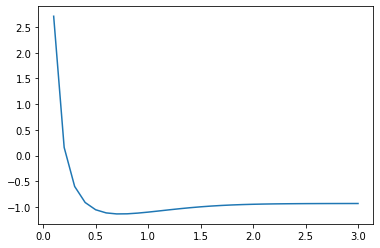

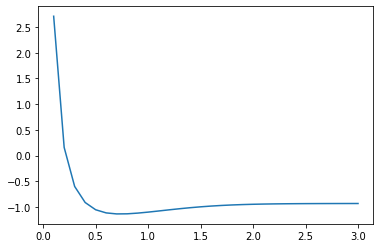

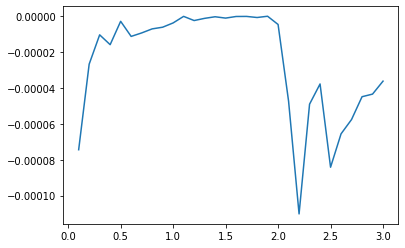

In [53]:
if __name__ == '__main__':
    main()